In [1]:
import os
import re
import matplotlib.pyplot as plt
from statistics import mean, median


def count_numbers_in_line(line):
    """Count the number of numbers (integers or floats) in a line."""
    return len(re.findall(r'-?\d+\.?\d*', line))

def process_files_in_folder(folder_path):
    """Process each file in the folder and return the combined list of numbers."""
    all_numbers = []

    # Iterate over all files in the folder
    clause_lengths = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Only process text files
        if os.path.isfile(file_path):
            with open(file_path, 'r') as file:
                for line in file:
                    # Count numbers in each line
                    if line.strip():
                        clause_lengths += [len(line.split())]
                    

    return clause_lengths

def plot_histogram(numbers, output_file, max_range = 120, title  = f'Size of Globally blocked clauses'):
    """Plot a histogram of the numbers and save it to a file."""
    plt.figure(figsize=(10, 6))
    plt.hist(numbers, bins=100, range=(0,max_range), edgecolor='black')
    plt.title('Size of Globally blocked clauses ' + title)
    plt.xlabel('Size of Clause')
    plt.ylabel('Frequency')
    plt.savefig(output_file)
    print(f'Histogram saved to {output_file}')

In [7]:
import re
import pandas as pd

def extract_results(file_path):
    pattern = re.compile(r"The file (.*?) returned (.*?) in time (.*?)!")
    data = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                file_name, result, time_limit = match.groups()
                data.append((file_name, result, time_limit))

    pattern = re.compile(r"The file (.*?) timed out in time (.*?)!")
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                file_name, time_limit = match.groups()
                data.append((file_name, "TIMEOUT", time_limit)) 
    
    df = pd.DataFrame(data, columns=["file_name", "result", "time_limit"])
    return df

original_df = extract_results("slurm-29474880.out")

# The file ae9522ea003ea9f75891b2d37a5e264b-srhd-sgi-m37-q446.25-n35-p30-s33692332.cnf returned SAT in time 4.4467597007751465!

print(original_df.to_string())

                                                                                                                   file_name   result           time_limit
0                                        bd8bc25be2b36c64b38459c17e815814-pcmax-scheduling-m11-1517-6802-UNSAT.sanitized.cnf    UNSAT    567.5721716880798
1                            1427381a809c64c721838894ece6756d-shuffling-2-s25242449-of-bench-sat04-727.used-as.sat04-753.cnf      SAT    35.90881872177124
2                                                                edceb8782e72e290fa54757dbfdd0173-x9-09057.sat.sanitized.cnf    UNSAT   379.53028893470764
3                                                                19e2c3a0865c8c1b4543d11213bebe5f-x9-09024.sat.sanitized.cnf    UNSAT    238.5542552471161
4                       303480ca7e8322d771c94caf4ebd4e95-circuit_48in64out_with_700gates_4in4out_dist128_seed1.sanitized.cnf      SAT   210.72448444366455
5                                                                     

In [3]:
import re
def extract_results_gbc(file_path):
    pattern = re.compile(r"The file (.*?) returned (.*?) in time (.*?)!")
    data = []
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                file_name, result, time_limit = match.groups()
                string_split = file_name.split("/")
                file_name, mutant_name = string_split[0] + ".cnf", string_split[1]
                data.append((file_name, mutant_name, result, time_limit))

    pattern = re.compile(r"The file (.*?) timed out in time (.*?)!")
    
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            match = pattern.search(line)
            if match:
                file_name, time_limit = match.groups()
                string_split = file_name.split("/")
                file_name, mutant_name = string_split[0] + ".cnf", string_split[1]
                data.append((file_name, mutant_name, "TIMEOUT", time_limit))
    
    df = pd.DataFrame(data, columns=["file_name", "mutant_name", "result", "time_limit"])
    return df

In [8]:
globally_blocked_clause_files = {
    "gbc0": "slurm-29479444.out",
    "gbc1": "slurm-29479445.out",
    "gbc2": "slurm-29479447.out",
    "gbc3": "slurm-29479448.out",
    "gbc4": "slurm-29479449.out",
    "gbc5": "slurm-29479450.out",
    "gbc6": "slurm-29479451.out",
    "gbc7": "slurm-29479554.out",
    "gbc8": "slurm-29479453.out",
    "gbc9": "slurm-29479454.out",
}

globally_blocked_clauses_dfs = {}

for key in globally_blocked_clause_files.keys():
    df = extract_results_gbc(globally_blocked_clause_files[key])
    globally_blocked_clauses_dfs[key] = df

# print(globally_blocked_clauses_dfs["gbc7"].to_string())

In [9]:
def process_and_validate_data(original_df, globally_blocked_clauses_dfs):
    conflicting_files = []
    results = []
    
    for file_name in original_df['file_name']:
        # Get original result and time
        original_row = original_df[original_df['file_name'] == file_name].iloc[0]
        original_result = original_row['result']
        # original_time = original_row['time_limit']
        original_time = pd.to_numeric(original_row['time_limit'], errors='coerce')
# result_df['min_time'] = pd.to_numeric(result_df['min_time'], errors='coerce')

        
        # Collect all matching entries from globally_blocked_clauses_dfs
        blocked_entries = []
        for df in globally_blocked_clauses_dfs.values():
            subset = df[df['file_name'] == file_name]
            if not subset.empty:
                blocked_entries.append(subset)
        
        if not blocked_entries:
            continue  # Skip if file_name does not appear in any globally blocked dataframe
        
        combined_df = pd.concat(blocked_entries)
        combined_df = combined_df.reset_index(drop=True)
        blocked_results = set(combined_df['result'])
        num_solutions = len(combined_df)

        # blocked_times = combined_df['time_limit']
        blocked_times = pd.to_numeric(combined_df['time_limit'], errors='coerce').dropna()

        if not blocked_times.empty:
            best_index = blocked_times.idxmin()
            if best_index in combined_df.index:
                best_performance_mutant = combined_df.loc[best_index, 'mutant_name']
            else:
                best_performance_mutant = None
        else:
            best_performance_mutant = None
        # if not blocked_times.empty:
        #     # Find all indices with the minimum time limit
        #     min_time = blocked_times.min()
        #     best_indexes = blocked_times[blocked_times == min_time].index
            
        #     if not best_indexes.empty:
        #         # Retrieve the 'mutant_name' values for all the rows with the minimum time limit
        #         best_performance_mutants = combined_df.loc[best_indexes, 'mutant_name'].tolist()
        #     else:
        #         best_performance_mutants = None
        # else:
        #     best_performance_mutants = None

        # if len(best_performance_mutants) == 1:
        #     best_performance_mutant = best_performance_mutants[0]
        # else:
        #     print(blocked_times)
        #     print(min_time)
        #     raise ValueError("multiple best performing mutants", best_performance_mutants)
        
        # Validate results
        if ('SAT' in blocked_results and 'UNSAT' == original_result) or ('UNSAT' in blocked_results and 'SAT' == original_result) or ('SAT' in blocked_results and 'UNSAT' in blocked_results):
            print(f"ERROR: {file_name}")
            conflicting_files.append(file_name)
        
        # Determine final result

        # if 'SAT' in blocked_results and 'UNSAT' in blocked_results:

        elif 'SAT' in blocked_results:
            final_result = 'SAT'
        elif 'UNSAT' in blocked_results:
            final_result = 'UNSAT'
        else:
            final_result = original_result
        
        # Aggregate time statistics
        # print(blocked_times.to_list())
        if not blocked_times.empty:
            min_time = blocked_times.min()
            max_time = blocked_times.max()
            median_time = blocked_times.median()

            # Sanity check
            if min_time > max_time:
                raise ValueError(f"Inconsistent min/max times for file {file_name}: min_time={min_time}, max_time={max_time}")
        else:
            min_time = max_time = median_time = None
        
        results.append({
            'file_name': file_name,
            'result': final_result,
            'original_time': original_time,
            'min_time': min_time,
            'max_time': max_time,
            'median_time': median_time,
            'num_solutions': num_solutions,
            'best_performance_mutant': best_performance_mutant.replace(".cnf", ""),
            # 'fixes': combined_df['mutant_name'].to_list()
        })
    
    if conflicting_files:
        raise ValueError(f'Conflicting results found for files: {conflicting_files}')
    
    return pd.DataFrame(results)


# Example usage
result_df = process_and_validate_data(original_df, globally_blocked_clauses_dfs)
print(result_df.to_string())

                                                                                                file_name   result  original_time     min_time     max_time  median_time  num_solutions                                                                                     best_performance_mutant
0                     bd8bc25be2b36c64b38459c17e815814-pcmax-scheduling-m11-1517-6802-UNSAT.sanitized.cnf    UNSAT     567.572172   516.581757   671.782132   581.429451             10                   bd8bc25be2b36c64b38459c17e815814-pcmax-scheduling-m11-1517-6802-UNSAT.sanitized_scramble0
1                                             edceb8782e72e290fa54757dbfdd0173-x9-09057.sat.sanitized.cnf    UNSAT     379.530289   353.234727   401.593665   394.542586              5                                           edceb8782e72e290fa54757dbfdd0173-x9-09057.sat.sanitized_scramble2
2                                             19e2c3a0865c8c1b4543d11213bebe5f-x9-09024.sat.sanitized.cnf    UNSAT     238.5

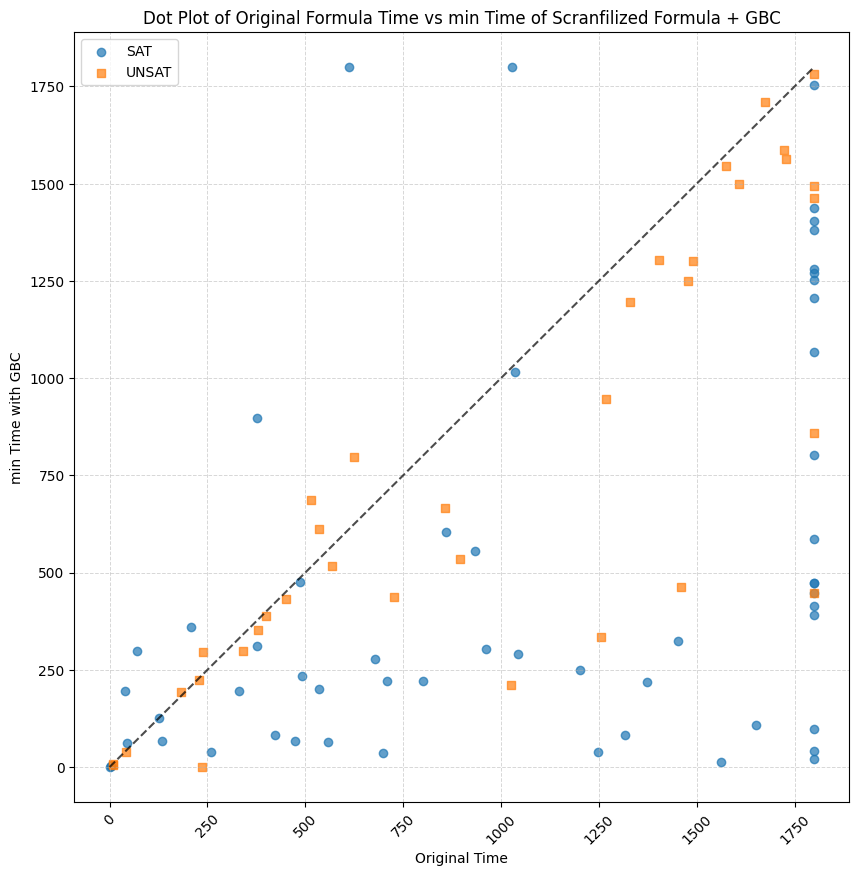

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate dot plot
def plot_dot_chart(result_df, mode):
    plt.figure(figsize=(10, 10))
    
    # Define marker styles for different results
    marker_styles = {'SAT': 'o', 'UNSAT': 's'}#, 'TIMEOUT': 'D'}
    
    # Create plot with different colors and markers
    for result_type, marker in marker_styles.items():
        subset = result_df[result_df['result'] == result_type]
        plt.scatter(subset['original_time'], subset[f'{mode}_time'], label=result_type, marker=marker, alpha=0.7)
    
    # Set axis labels and title
    plt.xlabel('Original Time')
    plt.ylabel(f'{mode} Time with GBC')
    plt.title(f'Dot Plot of Original Formula Time vs {mode} Time of Scranfilized Formula + GBC')
    
    # Adjust x-axis and y-axis scales to show proper numbers
    plt.xticks(rotation=45)
    plt.yticks()
    
    # Add an x=y reference line
    # min_val = min(result_df['original_time'].min(), result_df['min_time'].min())
    # max_val = max(result_df['original_time'].max(), result_df['min_time'].max())
    plt.plot([0, 1800], [0, 1800], linestyle='--', color='black', alpha=0.7, label='')
    
    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.7)
    plt.legend()
    # plt.show()
    plt.savefig(f'original_vs_{mode}_gbc_3.6.png')

plot_dot_chart(result_df, 'min')

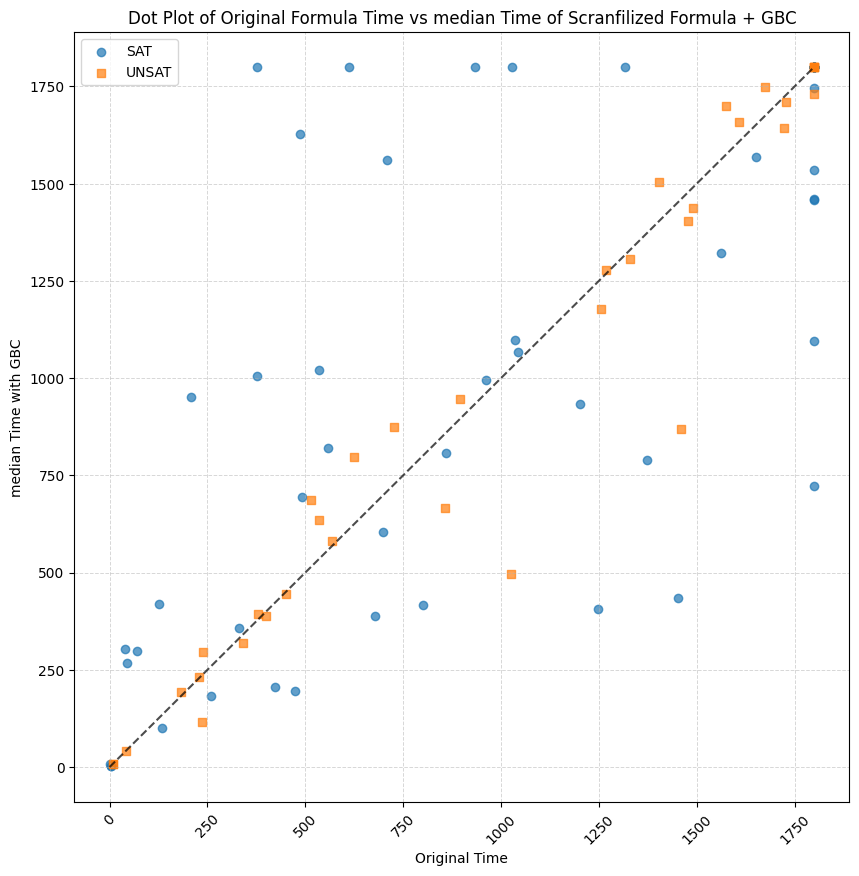

In [11]:
plot_dot_chart(result_df, 'median')

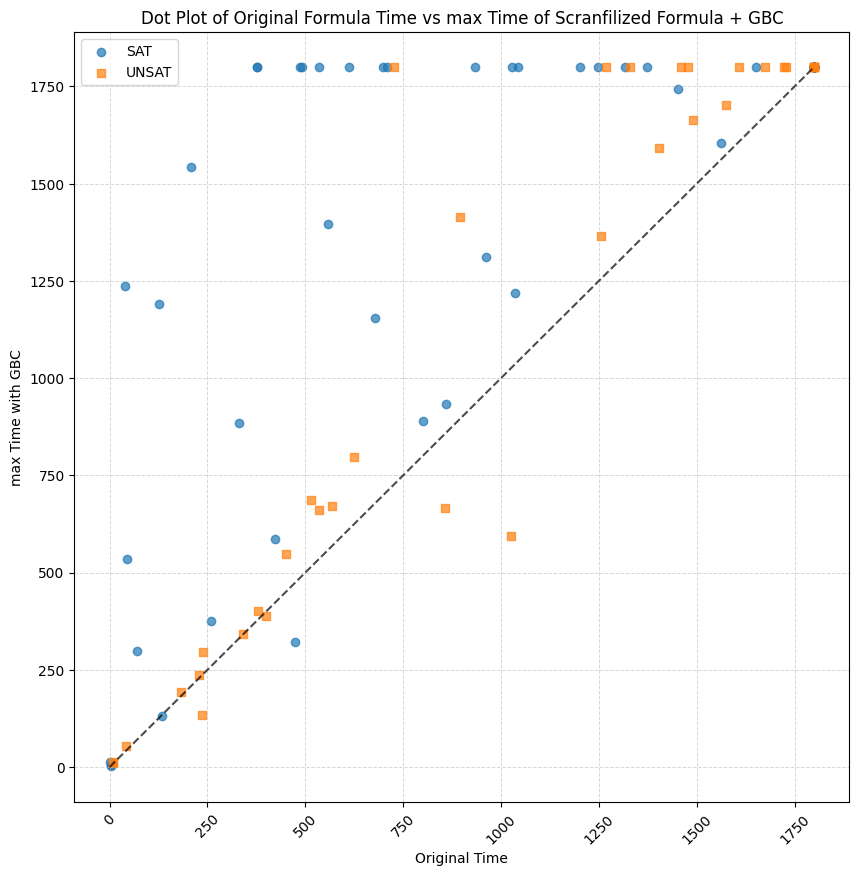

In [12]:
plot_dot_chart(result_df, 'max')


In [13]:
# Assuming results_df is already defined and loaded with data

# Function to process each row in the DataFrame
def process_row(row):
    file_name = row['file_name']
    mutant_name = row['best_performance_mutant']

    # Define the file paths based on the given pattern
    file_name_without_cnf = file_name.replace(".cnf", "")
    mutant_name_without_scramble = mutant_name.replace("scramble", "")
    
    global_clauses_path = f"results_scranfilized/{file_name_without_cnf}/{mutant_name}/global_clauses/{mutant_name_without_scramble}.global_clauses.txt"
    filtered_clauses_path = f"results_scranfilized/{file_name_without_cnf}/{mutant_name}/global_clauses/{mutant_name_without_scramble}.global_clauses.txt.filtered"
    
    # Check if the files exist
    if not os.path.exists(global_clauses_path) or not os.path.exists(filtered_clauses_path):
        raise FileNotFoundError(f"One of the files does not exist: {global_clauses_path} or {filtered_clauses_path}")
    
    # Read the filtered file to analyze the line lengths
    with open(filtered_clauses_path, 'r') as f:
        lines = f.readlines()
    
    num_gbc_unfiltered = sum(1 for line in open(global_clauses_path))
    num_gbc_filtered = len(lines)
    
    # Get the lengths of each line
    line_lengths = [len(line.split()) for line in lines]
    
    # Calculate the smallest length and frequency of that length
    # print(filtered_clauses_path)
    smallest_gbc_length = "N/A" if line_lengths == [] else min(line_lengths)
    freq_smallest_gbc_length = "N/A" if line_lengths == [] else line_lengths.count(smallest_gbc_length)
    
    # print("here")
    return pd.Series({
        "num gbc unfiltered": num_gbc_unfiltered,
        "num gbc filtered": num_gbc_filtered,
        "smallest gbc length": smallest_gbc_length,
        "freq. smallest gbc length": freq_smallest_gbc_length
    })

# Apply the function to each row in the DataFrame

result_df_new_info = result_df
result_df_new_info[['num gbc unfiltered', 'num gbc filtered', 'smallest gbc length', 'freq smallest gbc length']] = result_df.apply(process_row, axis=1)

In [14]:
print(result_df_new_info.to_string())

result_df_new_info.to_csv("results_3.6.csv")

                                                                                                file_name   result  original_time     min_time     max_time  median_time  num_solutions                                                                                     best_performance_mutant  num gbc unfiltered  num gbc filtered smallest gbc length freq smallest gbc length
0                     bd8bc25be2b36c64b38459c17e815814-pcmax-scheduling-m11-1517-6802-UNSAT.sanitized.cnf    UNSAT     567.572172   516.581757   671.782132   581.429451             10                   bd8bc25be2b36c64b38459c17e815814-pcmax-scheduling-m11-1517-6802-UNSAT.sanitized_scramble0                 162               140                   7                        1
1                                             edceb8782e72e290fa54757dbfdd0173-x9-09057.sat.sanitized.cnf    UNSAT     379.530289   353.234727   401.593665   394.542586              5                                           edceb8782e72e290fa54757d

In [17]:
original_files = {
    "df0": "slurm-29487980.out",
    "df1": "slurm-29487981.out",
    "df2": "slurm-29487982.out",
    "df3": "slurm-29487983.out",
    "df4": "slurm-29487984.out",
    "df5": "slurm-29487985.out",
    "df6": "slurm-29487986.out",
    "df7": "slurm-29487988.out",
    "df8": "slurm-29487989.out",
    "df9": "slurm-29487990.out",
}

original_dfs = {}

for key in original_files.keys():
    df = extract_results_gbc(original_files[key])
    original_dfs[key] = df

# print(original_dfs["df6"].to_string())

In [18]:

def process_and_validate_data(original_df, original_dfs):
    conflicting_files = []
    results = []
    
    for file_name in original_df['file_name']:
        # Get original result and time
        original_row = original_df[original_df['file_name'] == file_name].iloc[0]
        original_result = original_row['result']
        # original_time = original_row['time_limit']
        # original_time = pd.to_numeric(original_row['original_time'], errors='coerce')
# result_df['min_time'] = pd.to_numeric(result_df['min_time'], errors='coerce')

        
        # Collect all matching entries from original_dfs
        blocked_entries = []
        for df in original_dfs.values():
            subset = df[df['file_name'] == file_name]
            if not subset.empty:
                blocked_entries.append(subset)
        
        if not blocked_entries:
            continue  # Skip if file_name does not appear in any globally blocked dataframe
        
        combined_df = pd.concat(blocked_entries)
        combined_df = combined_df.reset_index(drop=True)
        blocked_results = set(combined_df['result'])
        num_solutions = len(combined_df)

        # blocked_times = combined_df['time_limit']
        blocked_times = pd.to_numeric(combined_df['time_limit'], errors='coerce').dropna()

        if not blocked_times.empty:
            best_index = blocked_times.idxmin()
            if best_index in combined_df.index:
                best_performance_mutant = combined_df.loc[best_index, 'mutant_name']
            else:
                best_performance_mutant = None
        else:
            best_performance_mutant = None
        # if not blocked_times.empty:
        #     # Find all indices with the minimum time limit
        #     min_time = blocked_times.min()
        #     best_indexes = blocked_times[blocked_times == min_time].index
            
        #     if not best_indexes.empty:
        #         # Retrieve the 'mutant_name' values for all the rows with the minimum time limit
        #         best_performance_mutants = combined_df.loc[best_indexes, 'mutant_name'].tolist()
        #     else:
        #         best_performance_mutants = None
        # else:
        #     best_performance_mutants = None

        # if len(best_performance_mutants) == 1:
        #     best_performance_mutant = best_performance_mutants[0]
        # else:
        #     print(blocked_times)
        #     print(min_time)
        #     raise ValueError("multiple best performing mutants", best_performance_mutants)
        
        # Validate results
        if ('SAT' in blocked_results and 'UNSAT' == original_result) or ('UNSAT' in blocked_results and 'SAT' == original_result) or ('SAT' in blocked_results and 'UNSAT' in blocked_results):
            print(f"ERROR: {file_name}")
            conflicting_files.append(file_name)
        
        # Determine final result

        # if 'SAT' in blocked_results and 'UNSAT' in blocked_results:

        elif 'SAT' in blocked_results:
            final_result = 'SAT'
        elif 'UNSAT' in blocked_results:
            final_result = 'UNSAT'
        else:
            final_result = original_result
        
        # Aggregate time statistics
        # print(blocked_times.to_list())
        if not blocked_times.empty:
            min_time = blocked_times.min()
            max_time = blocked_times.max()
            median_time = blocked_times.median()

            # Sanity check
            if min_time > max_time:
                raise ValueError(f"Inconsistent min/max times for file {file_name}: min_time={min_time}, max_time={max_time}")
        else:
            min_time = max_time = median_time = None
        
        original_row_dict = original_row.to_dict()

        original_row_dict.update ( {
            # 'file_name': file_name,
            # 'result': final_result,
            # 'original_time': original_time,
            'min_time_original': min_time,
            'max_time_original': max_time,
            'median_time_original': median_time,
            'best_performance_mutant_original': best_performance_mutant.replace(".cnf", ""),
            # 'fixes': combined_df['mutant_name'].to_list()
        })

        results.append(original_row_dict)
    
    if conflicting_files:
        raise ValueError(f'Conflicting results found for files: {conflicting_files}')
    
    return pd.DataFrame(results)


# Example usage
result_df_multiple_originals = process_and_validate_data(result_df_new_info, original_dfs)
print(result_df_multiple_originals.to_string())

                                                                                                file_name   result  original_time     min_time     max_time  median_time  num_solutions                                                                                     best_performance_mutant  num gbc unfiltered  num gbc filtered smallest gbc length freq smallest gbc length  min_time_original  max_time_original  median_time_original                                                                            best_performance_mutant_original
0                     bd8bc25be2b36c64b38459c17e815814-pcmax-scheduling-m11-1517-6802-UNSAT.sanitized.cnf    UNSAT     567.572172   516.581757   671.782132   581.429451             10                   bd8bc25be2b36c64b38459c17e815814-pcmax-scheduling-m11-1517-6802-UNSAT.sanitized_scramble0                 162               140                   7                        1         508.761469         735.870850            630.111068                   bd8b

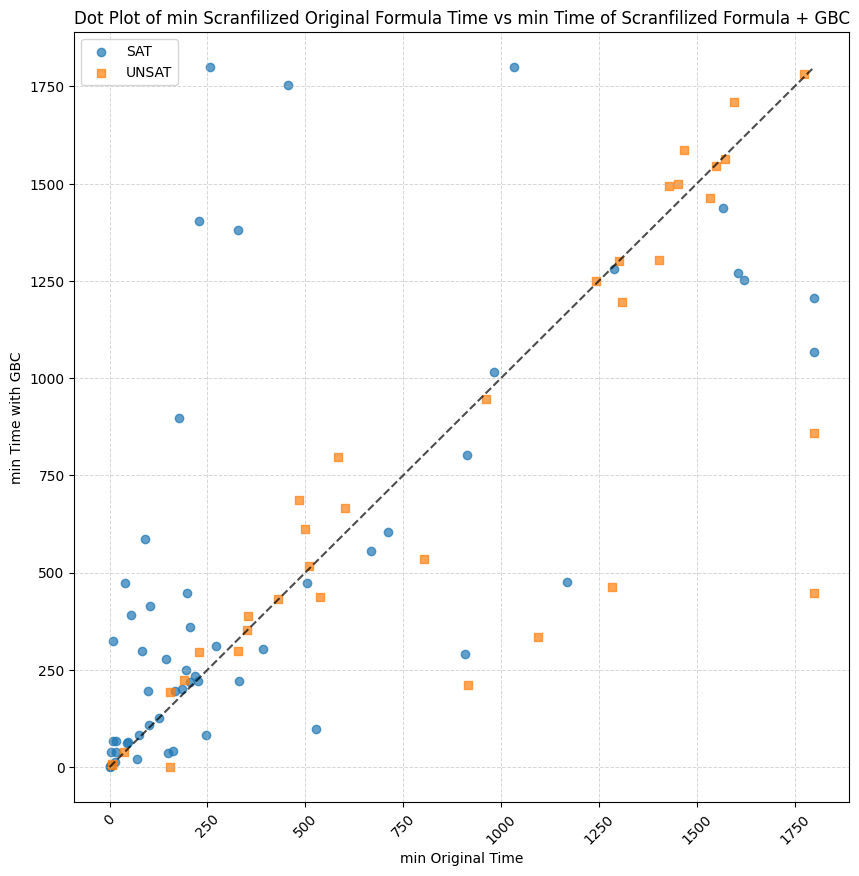

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to generate dot plot
def plot_dot_chart_multiple_originals(result_df, mode):
    plt.figure(figsize=(10, 10))
    
    # Define marker styles for different results
    marker_styles = {'SAT': 'o', 'UNSAT': 's'}#, 'TIMEOUT': 'D'}
    
    # Create plot with different colors and markers
    for result_type, marker in marker_styles.items():
        subset = result_df[result_df['result'] == result_type]
        plt.scatter(subset[f'{mode}_time_original'], subset[f'{mode}_time'], label=result_type, marker=marker, alpha=0.7)
    
    # Set axis labels and title
    plt.xlabel(f'{mode} Original Time')
    plt.ylabel(f'{mode} Time with GBC')
    plt.title(f'Dot Plot of {mode} Scranfilized Original Formula Time vs {mode} Time of Scranfilized Formula + GBC')
    
    # Adjust x-axis and y-axis scales to show proper numbers
    plt.xticks(rotation=45)
    plt.yticks()
    
    # Add an x=y reference line
    # min_val = min(result_df['original_time'].min(), result_df['min_time'].min())
    # max_val = max(result_df['original_time'].max(), result_df['min_time'].max())
    plt.plot([0, 1800], [0, 1800], linestyle='--', color='black', alpha=0.7, label='')
    
    # Customize grid
    plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.7)
    plt.legend()
    # plt.show()
    plt.savefig(f'{mode}_original_vs_{mode}_gbc_3.6.png')

plot_dot_chart_multiple_originals(result_df_multiple_originals, 'min')


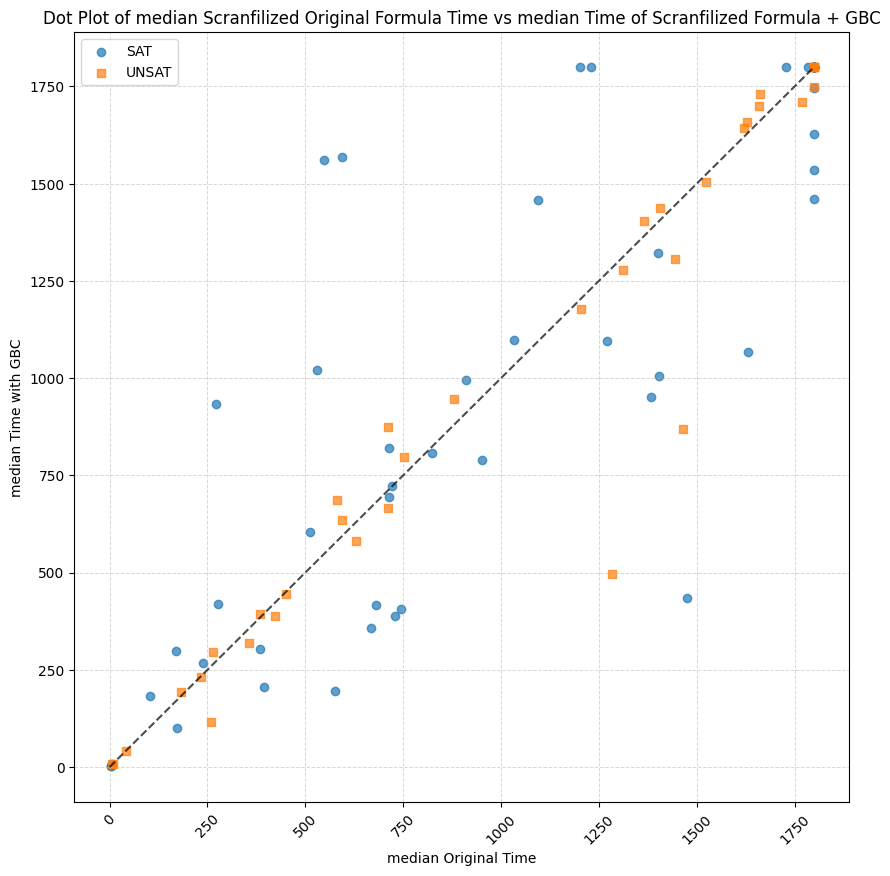

In [21]:
plot_dot_chart_multiple_originals(result_df_multiple_originals, 'median')

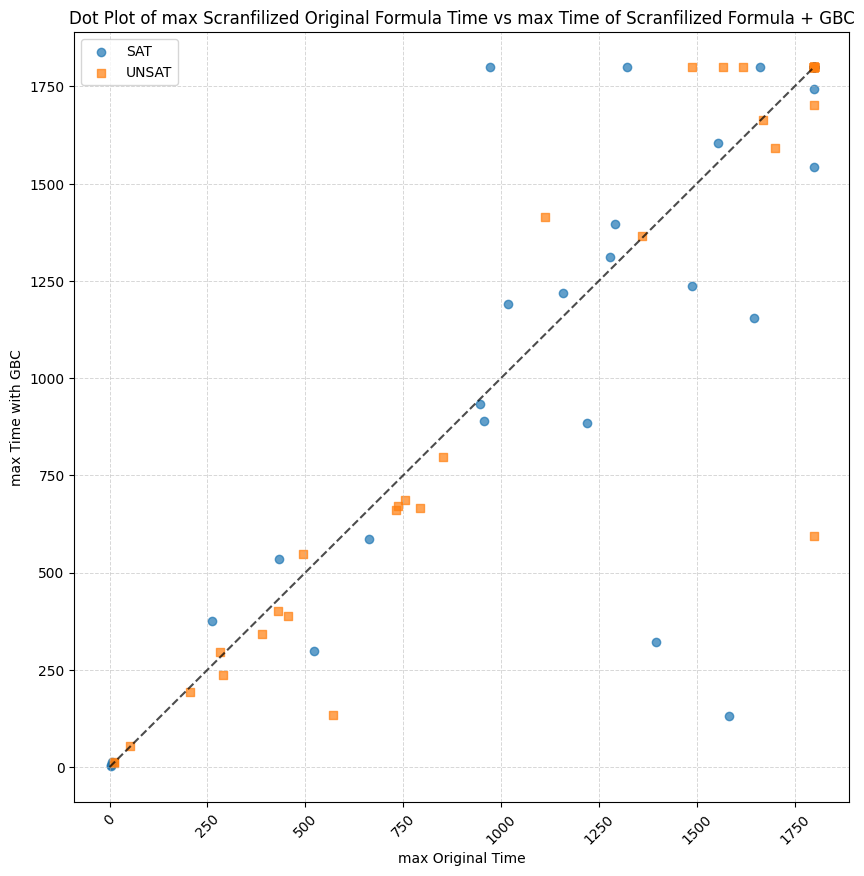

In [22]:
plot_dot_chart_multiple_originals(result_df_multiple_originals, 'max')